# Fiscal policy criteria for fixed-income allocation

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Run only if needed!
#"""!pip install macrosynergy --upgrade"""

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

C:\Users\GlennRegis\.conda\envs\msynb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).

In [3]:
cids = [
    "AUD",
    "CAD",
    "CHF",
    "CNY",
    "EUR",
    "GBP",
    "HKD",
    "INR",
    "JPY",
    "KRW",
    "MXN",
    "MYR",
    "PLN",
    "SEK",
    "SGD",
    "THB",
    "TRY",
    "TWD",
    "USD",
    "ZAR",
]

In [4]:
# Categories

main = [
    "GGOBGDPRATIO_NSA",
    "GGSBGDPRATIO_NSA",
    "GGFTGDPRATIO_NSA",
    "EXALLOPENNESS_NSA_1YMA",
]

rets = [
    "DU05YXR_NSA",
    "DU05YXR_VT10",
]

xcats = main + rets

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 120


JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [General government finance ratios](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/General%20government%20finance%20ratios.php?highlight=ggobgdpratio), [Economic openness ratios](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Economic%20openness%20ratios.php?highlight=exallopenness), and [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php).

In [5]:
start_date = "2000-01-01"
end_date = "2023-05-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        suppress_warning=True,
        metrics=["all"],
        show_progress=True,
    )

Timestamp UTC:  2024-07-29 15:11:16
Connection successful!


Requesting data: 100%|████████████████████| 24/24 [00:04<00:00,  4.91it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
8 out of 480 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.


### Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

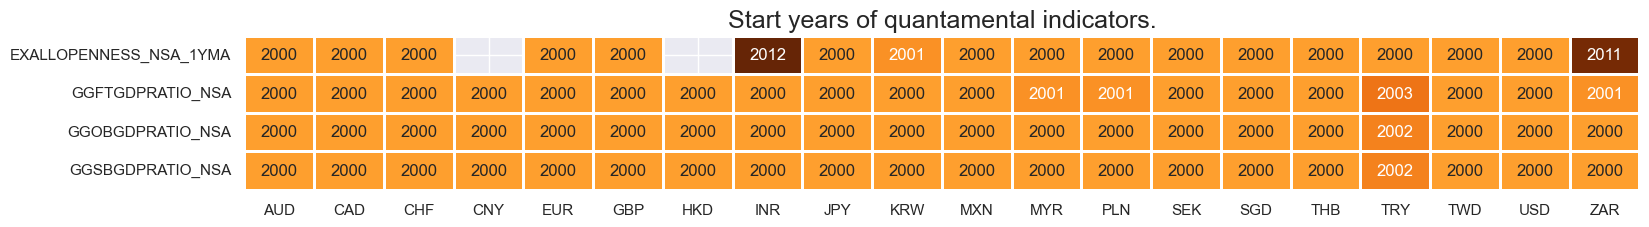

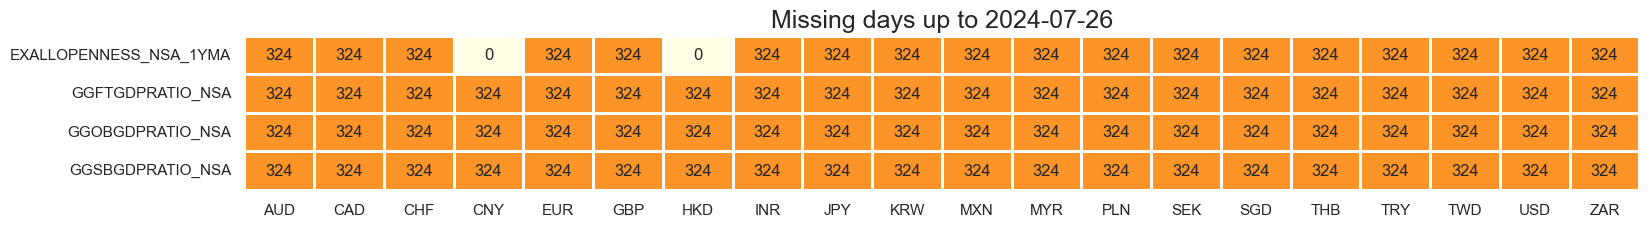

In [6]:
msm.check_availability(df, xcats=main, cids=cids)

### Take out bad-data return periods for fixed income markets

In [7]:
dfx = df.copy()
filt_du = dfx["xcat"].isin(["DU05YXR_NSA", "DU05YXR_VT10"])
filt_try = (dfx["cid"] == "TRY") & (dfx["real_date"] > pd.to_datetime("2022-08-01"))
filt_myr = (
    (dfx["cid"] == "MYR")
    & (dfx["real_date"] > pd.to_datetime("2014-02-01"))
    & (dfx["real_date"] < pd.to_datetime("2014-07-01"))
)

filt_all = filt_du & (filt_try | filt_myr)

dfx.loc[filt_all, "value"] = np.nan

The graph presented below indicates the rationale behind excluding two periods for the Turkish Lira (TRY) starting from 2022 due to a significant spike in the data. Additionally, it highlights the lack of data available for the Malaysian Ringgit (MYR) in the year 2014.

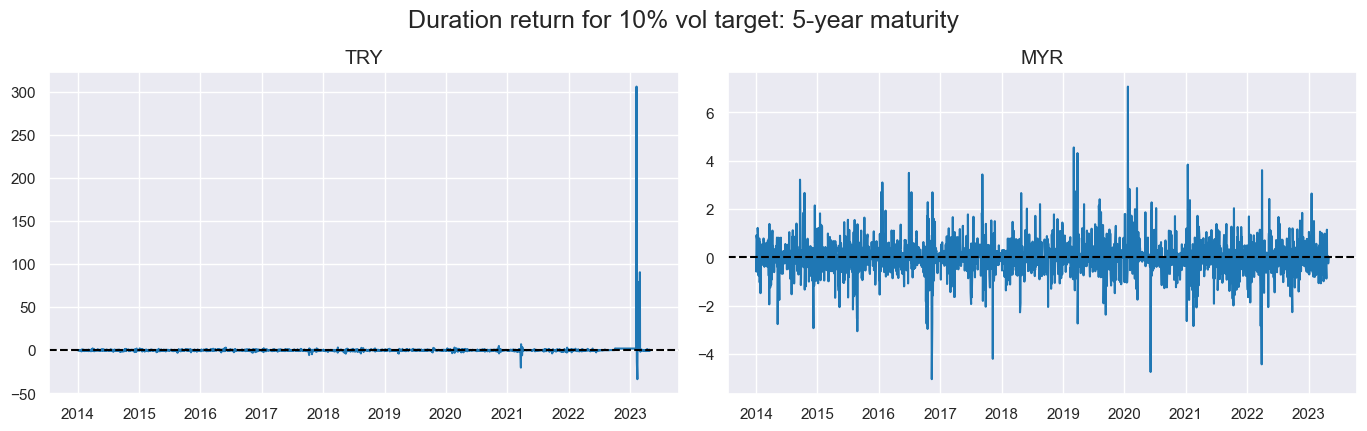

In [8]:
msp.view_timelines(
    df,
    xcats=["DU05YXR_VT10"],
    cids=["TRY", "MYR"],
    ncol=2,
    cumsum=False,
    start="2014-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title="Duration return for 10% vol target: 5-year maturity",
   
)

## Transformations and checks

## Features

For tracking the fiscal stance in a comparable fashion across countries we focus on two sets of quantamental indicators: The first set is the general government balance ratios defined as the sum of central, state and local governments as a percent of GDP. More details and timelines are under [General government finance ratios](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/General%20government%20finance%20ratios.php?highlight=ggobgdpratio). The second set of indicators is fiscal thrust, also called fiscal stimulus.

### Balances and gaps

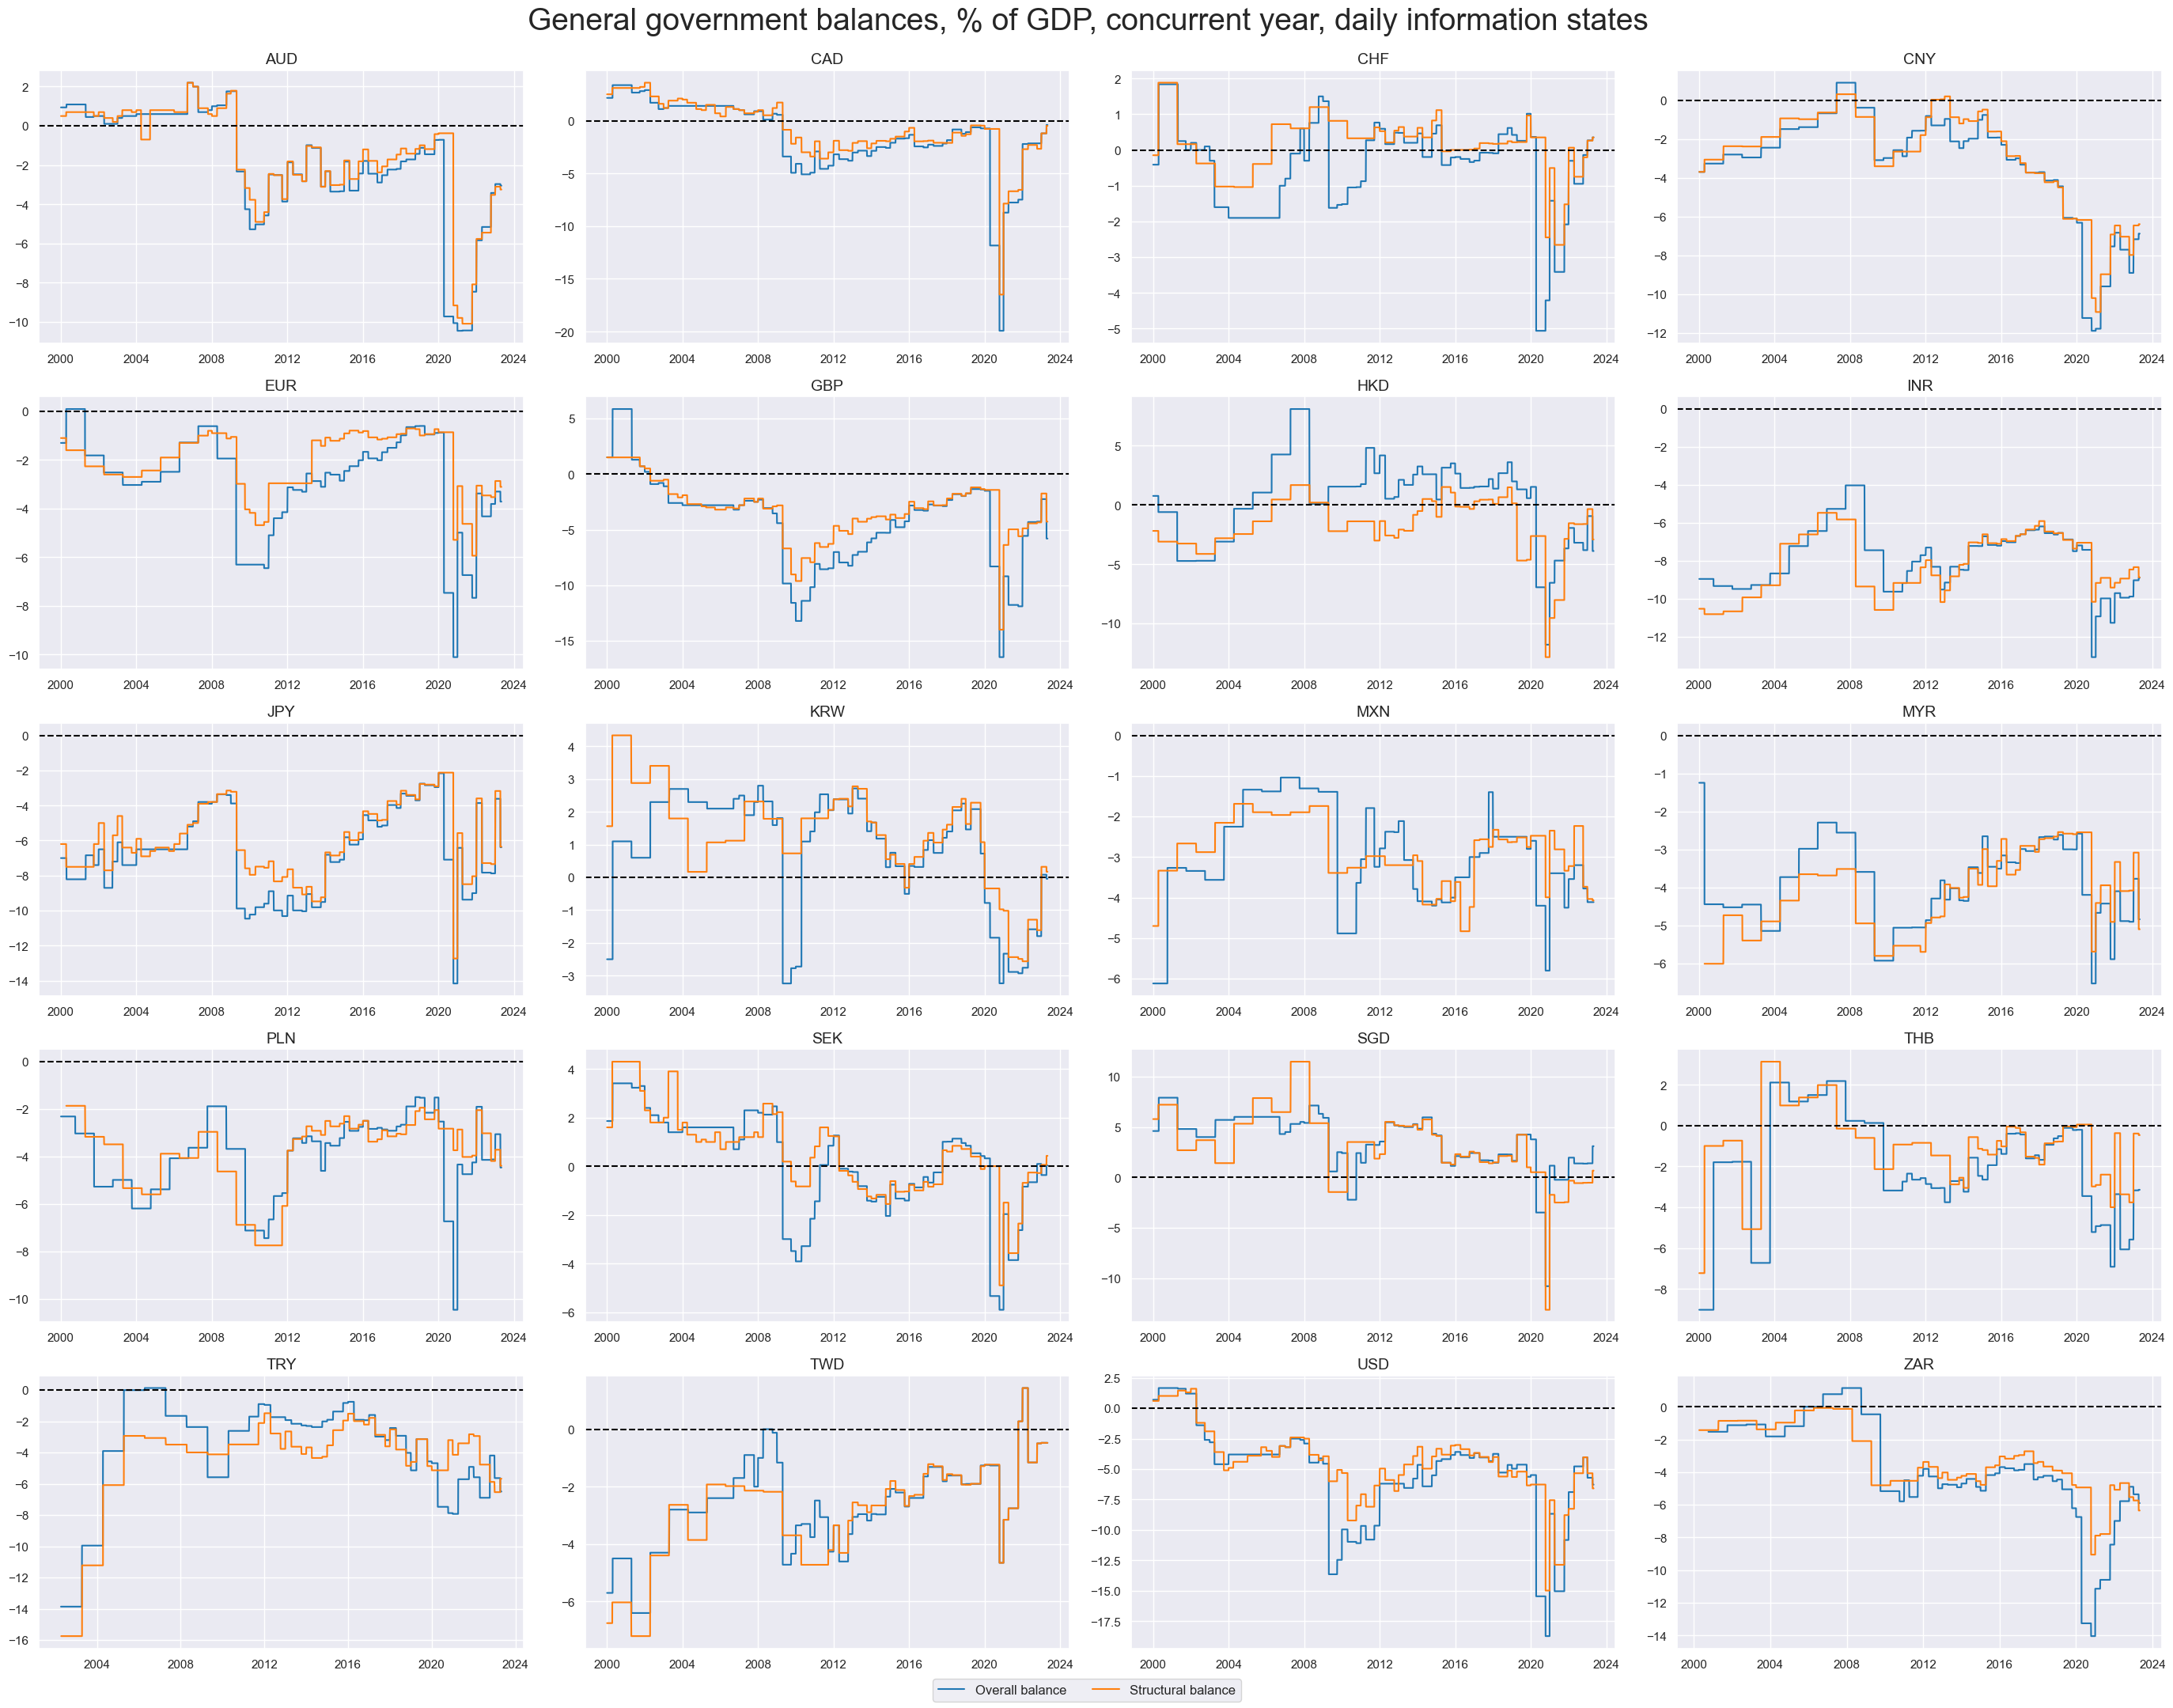

In [9]:
cidx = cids
xcatx = ["GGOBGDPRATIO_NSA", "GGSBGDPRATIO_NSA"]

msp.view_timelines(
    df,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title="General government balances, % of GDP, concurrent year, daily information states",
    xcat_labels=["Overall balance", "Structural balance"],
    title_fontsize=28
)

We define `Balance Gap`  as the average of  overall and structural general government balance, % of GDP

In [10]:
calcs = [
    "BALS_GAP = GGSBGDPRATIO_NSA + 3 ",
    "BALO_GAP = GGOBGDPRATIO_NSA + 3 ",
    "BALA_GAP = ( BALS_GAP + BALO_GAP ) / 2",  # replace by linear combination
]

dfa = msp.panel_calculator(df, calcs, cids=cids)

dfx = msm.update_df(dfx, dfa)

### Fiscal thrust

[General government fiscal thrust](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/General%20government%20finance%20ratios.php?highlight=ggftgdpratio): Fiscal thrust, also called fiscal stimulus, measures the direct impact of fiscal policy on aggregate demand in the economy. Here it is approximated by the negative of the difference between a country’s (expected or estimated) structural balance as % of GDP in the current year versus the previous year. Since structural balances are adjusted for the impact of business cycles and terms-of-trade they are indicative of the stance of fiscal policy, i.e. the effect of discretionary fiscal measures on the economy. A positive value means that the structural balance shifts towards deficit and that fiscal policy looks expansionary. A negative value means that the structural balance has shifted towards surplus and that policy is restrictive.

In [11]:
calcs = [
    "THRUST = GGFTGDPRATIO_NSA ",
    "THRUST_AO = THRUST / EXALLOPENNESS_NSA_1YMA",
]

dfa = msp.panel_calculator(df, calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

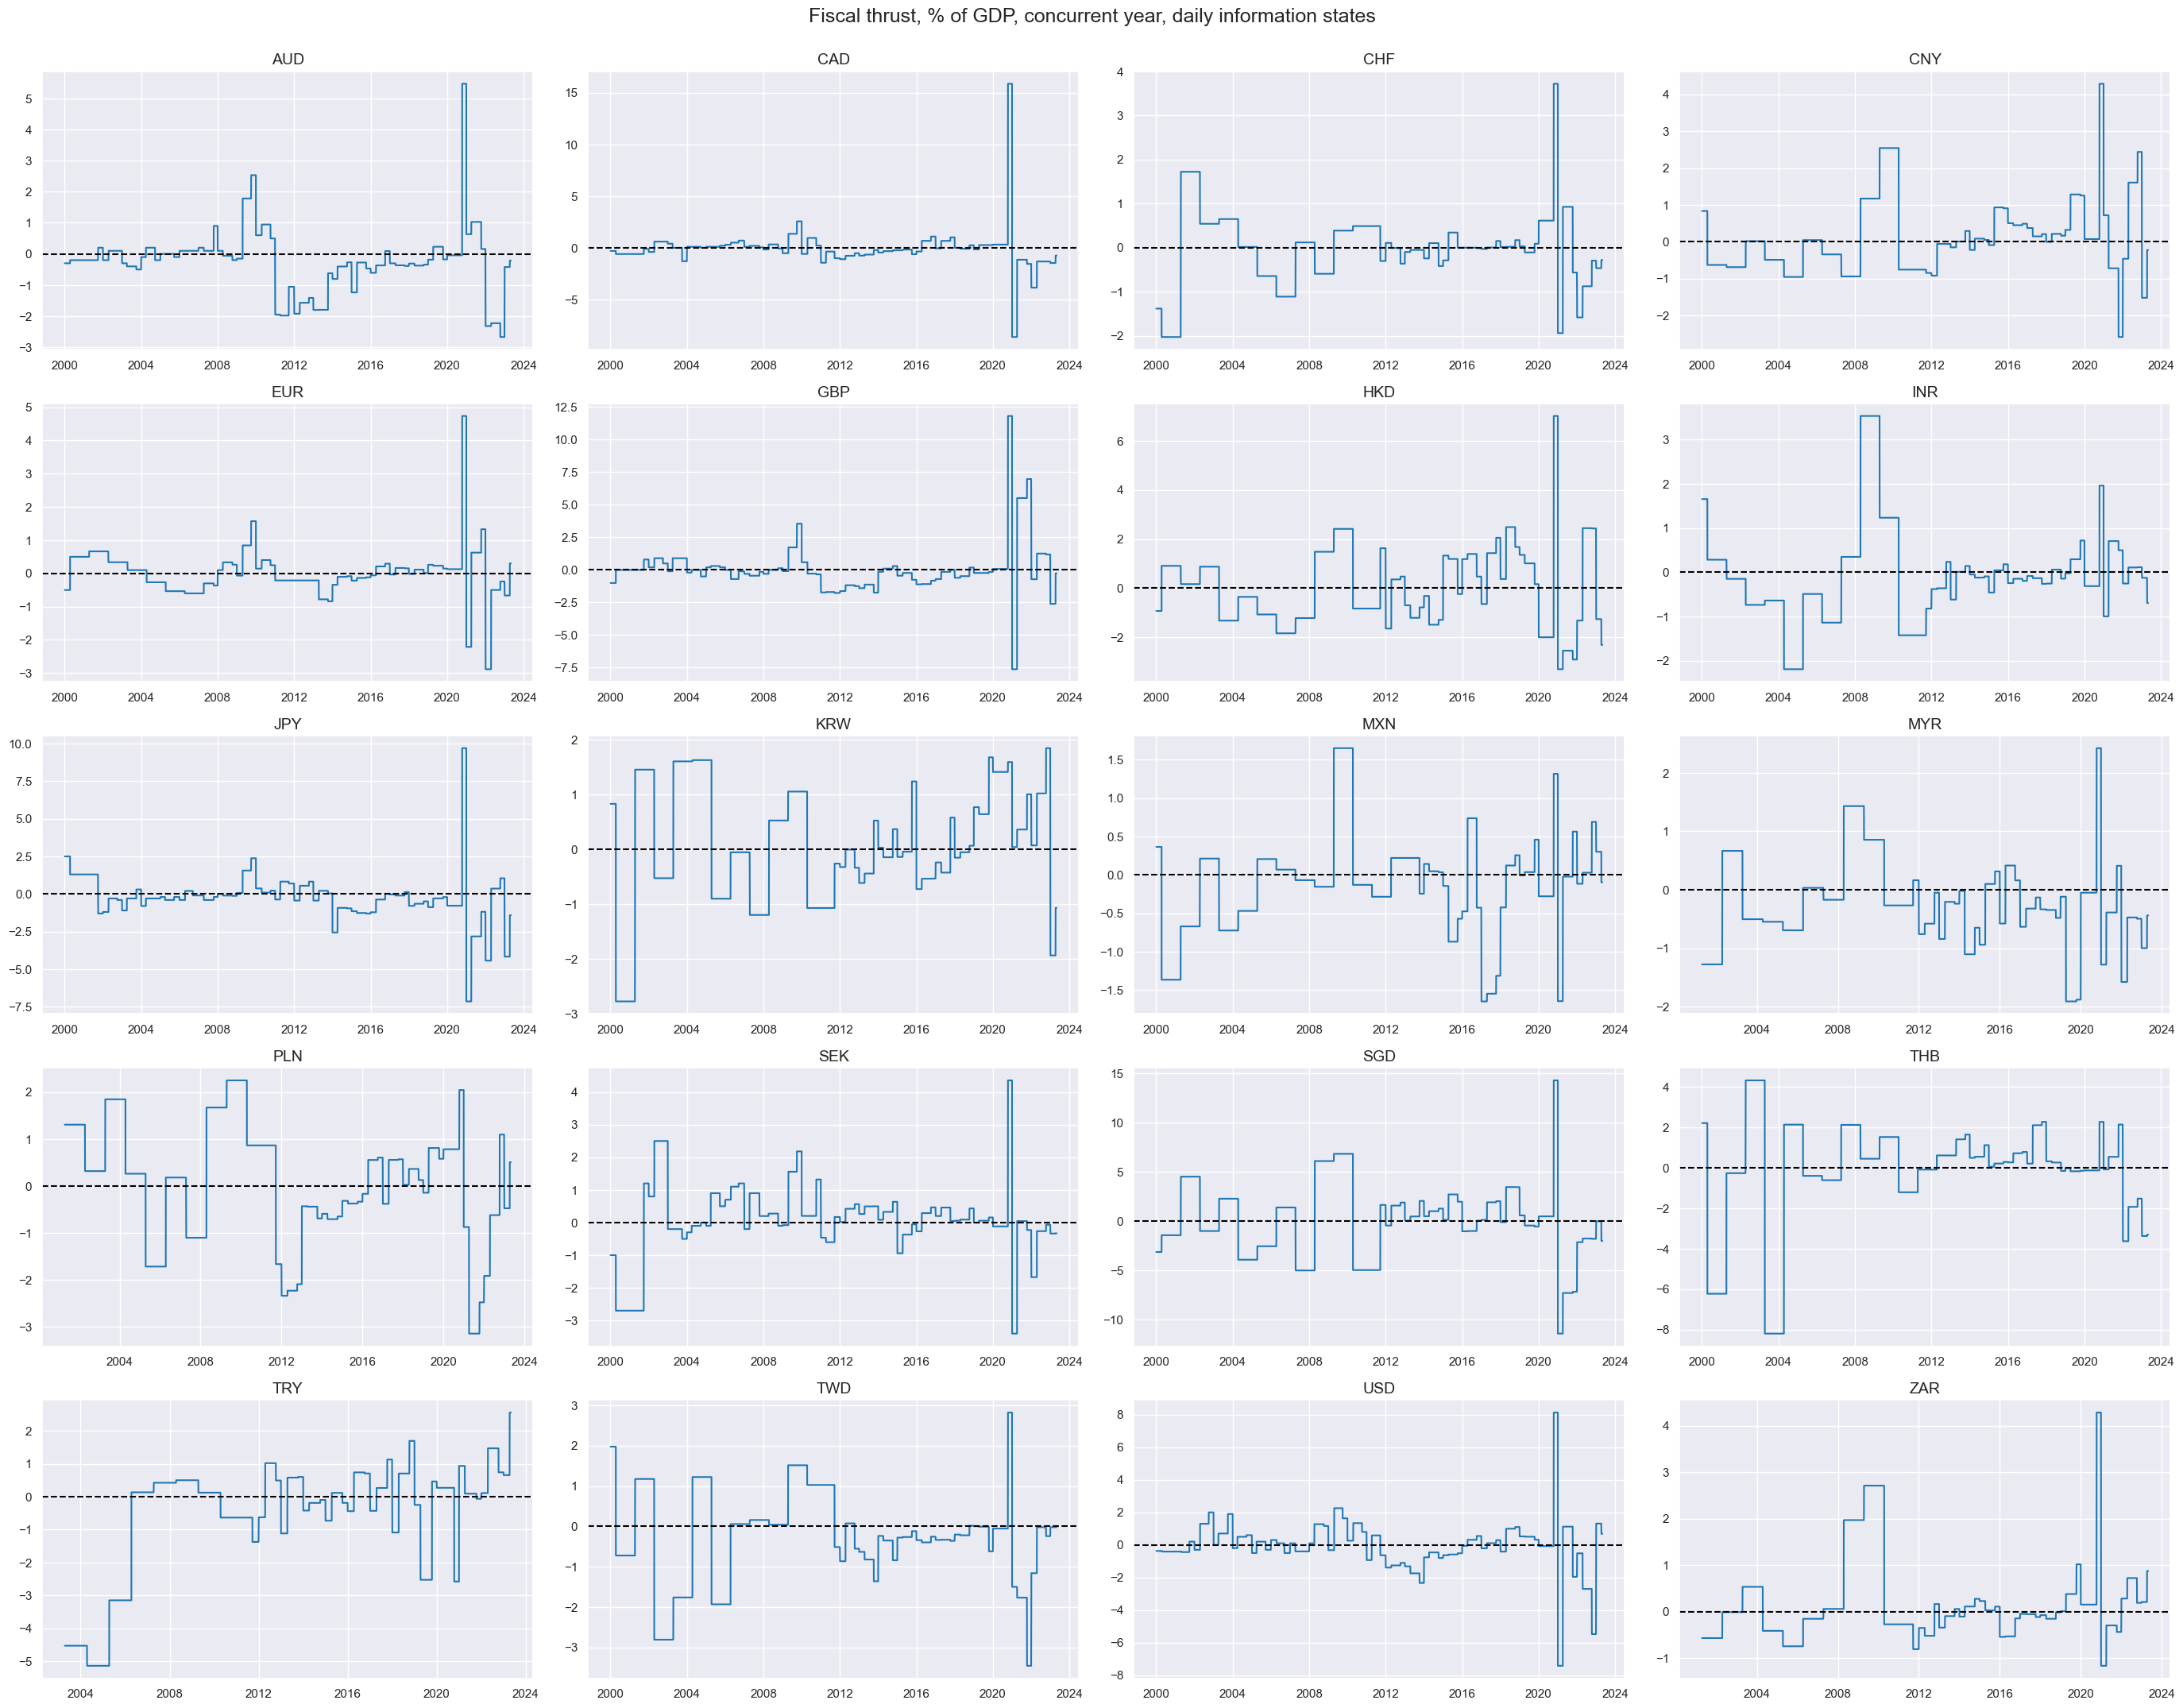

In [12]:
cidx = cids
xcatx = ["THRUST"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title="Fiscal thrust, % of GDP, concurrent year, daily information states",
  )

### Composite fiscal score

To create a simple fiscal policy score that combines the two sets of indicators, namely the General Government Balance Ratios and General Government Fiscal Thrust, the following steps are taken: 

Normalization: Each indicator (balance ratios and fiscal thrust) is normalized using z-scores. This process standardizes the data, making it easier to compare different countries on the same scale.

Winsorization: After normalization, extreme values are winsorized at 3 standard deviations. Winsorization involves capping or truncating extreme values to minimize the influence of outliers on the overall score.

Weighting: Each indicator is given a weight to determine its relative importance in the final score. In this case, both budget balances (General Government Balance Ratios) and fiscal thrust (General Government Fiscal Thrust) are given equal weights, each accounting for 50% of the overall score.

The resulting score provides a combined measure of a country's fiscal policy performance, taking into account both its budget balances and the impact of fiscal measures on aggregate demand. By applying equal weights to both sets of indicators, the score ensures that each component contributes equally to the overall assessment of the country's fiscal policy stance.

In [13]:
cidx = cids
xcatx = ["BALA_GAP", "THRUST"]

for xc in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=2 * 261,
        neutral="zero",
        pan_weight=1,
        thresh=3,
        postfix="ZN",
    )
    dfx = msm.update_df(dfx, dfa)

In [14]:
dict_fcs = {
    "BALTHRUST_XCS": [
        ["BALA_GAPZN", "THRUSTZN"],
        None,
        [1, -1],
    ],
}

cidx = cids
dfa = pd.DataFrame(columns=dfx.columns)

for key, values in dict_fcs.items():
    dfaa = msp.linear_composite(
        dfx,
        xcats=values[0],
        weights=values[1],
        signs=values[2],
        cids=cidx,
        complete_xcats=False,
        new_xcat=key,
    )
    dfaa["xcat"] = key
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

### Relative features & targets

#### Balance and duration

In [15]:
dict_new = {"fix": "vGLB_BAL"}
dict_new["xcats"] = [
    "BALA_GAP",
    "DU05YXR_VT10",
]
dfxx = dfx[dfx["xcat"].isin(dict_new["xcats"])]
dfxw = dfxx.pivot(index=["cid", "real_date"], columns="xcat", values="value")

available = dfxw.isna().any(axis=1).astype(int).groupby("cid").mean() == 1
dict_new["cids"] = list(available.index[available < 1].intersection(cids))

dfba = dfxw.isna().any(axis=1).astype(int).reset_index().rename({0: "value"}, axis=1)
dfba["xcat"] = "BLACK"
dict_new["black"] = msp.make_blacklist(dfba, "BLACK")

display(len(dict_new["cids"]), dict_new["cids"])

dict_bal = dict_new.copy()

20

['AUD',
 'CAD',
 'CHF',
 'CNY',
 'EUR',
 'GBP',
 'HKD',
 'INR',
 'JPY',
 'KRW',
 'MXN',
 'MYR',
 'PLN',
 'SEK',
 'SGD',
 'THB',
 'TRY',
 'TWD',
 'USD',
 'ZAR']

We use `make_relative_value()` function from the `macrosynergy` package to generate relative values for `Balance Gap` and Duration returns. “Relative” means that the original value is compared to a basket average. By default, the basket consists of all available cross-sections, and the relative value is calculated by subtracting the basket average from individual cross-section values. The new TimeSeries gets postfix `vGLB_BAL` as specified in the cell above

In [16]:
dix = dict_bal

dfa = msp.make_relative_value(
    dfx,
    xcats=dix["xcats"],
    cids=dix["cids"],
    start="2000-01-01",
    rel_meth="subtract",
    postfix=dix["fix"],
    blacklist=dix["black"],
)
dfx = msm.update_df(dfx, dfa)

#### Thrust and duration

In [17]:
dict_new = {"fix": "vGLB_THR"}
dict_new["xcats"] = [
    "THRUST",
    "DU05YXR_VT10",
]
dfxx = dfx[dfx["xcat"].isin(dict_new["xcats"])]
dfxw = dfxx.pivot(index=["cid", "real_date"], columns="xcat", values="value")

available = dfxw.isna().any(axis=1).astype(int).groupby("cid").mean() == 1
dict_new["cids"] = list(available.index[available < 1].intersection(cids))

dfba = dfxw.isna().any(axis=1).astype(int).reset_index().rename({0: "value"}, axis=1)
dfba["xcat"] = "BLACK"
dict_new["black"] = msp.make_blacklist(dfba, "BLACK")
display(len(dict_new["cids"]), dict_new["cids"])

dict_thr = dict_new.copy()

20

['AUD',
 'CAD',
 'CHF',
 'CNY',
 'EUR',
 'GBP',
 'HKD',
 'INR',
 'JPY',
 'KRW',
 'MXN',
 'MYR',
 'PLN',
 'SEK',
 'SGD',
 'THB',
 'TRY',
 'TWD',
 'USD',
 'ZAR']

We use `make_relative_value()` function from the `macrosynergy` package to generate relative values for Thrust and Duration returns. As before, “relative” means that the original value is compared to a basket average. By default, the basket consists of all available cross-sections, and the relative value is calculated by subtracting the basket average from individual cross-section values. The new TimeSeries get postfix `vGLB_THR` as specified in the cell above

In [18]:
dix = dict_thr

dfa = msp.make_relative_value(
    dfx,
    xcats=dix["xcats"],
    cids=dix["cids"],
    start="2000-01-01",
    rel_meth="subtract",
    postfix=dix["fix"],
    blacklist=dix["black"],
)
dfx = msm.update_df(dfx, dfa)

#### Composite and duration

Here we repeat the same process for the composite balance/thrust indicator and duration returns. We give the new TimeSeries postfix `vGLB_CS`

In [19]:
dict_new = {"fix": "vGLB_CS"}
dict_new["xcats"] = [
    "BALTHRUST_XCS",
    "DU05YXR_VT10",
]
dfxx = dfx[dfx["xcat"].isin(dict_new["xcats"])]
dfxw = dfxx.pivot(index=["cid", "real_date"], columns="xcat", values="value")

available = dfxw.isna().any(axis=1).astype(int).groupby("cid").mean() == 1
dict_new["cids"] = list(available.index[available < 1].intersection(cids))

dfba = dfxw.isna().any(axis=1).astype(int).reset_index().rename({0: "value"}, axis=1)
dfba["xcat"] = "BLACK"
dict_new["black"] = msp.make_blacklist(dfba, "BLACK")
display(len(dict_new["cids"]), dict_new["cids"])

dict_cs = dict_new.copy()

20

['AUD',
 'CAD',
 'CHF',
 'CNY',
 'EUR',
 'GBP',
 'HKD',
 'INR',
 'JPY',
 'KRW',
 'MXN',
 'MYR',
 'PLN',
 'SEK',
 'SGD',
 'THB',
 'TRY',
 'TWD',
 'USD',
 'ZAR']

In [20]:
dix = dict_cs

dfa = msp.make_relative_value(
    dfx,
    xcats=dix["xcats"],
    cids=dix["cids"],
    start="2000-01-01",
    rel_meth="subtract",
    postfix=dix["fix"],
    blacklist=dix["black"],
)
dfx = msm.update_df(dfx, dfa)

To display the results and to compare the absolute and relative balance/thrust indicator we use `view_timelines` function from the `macrosynergy` package

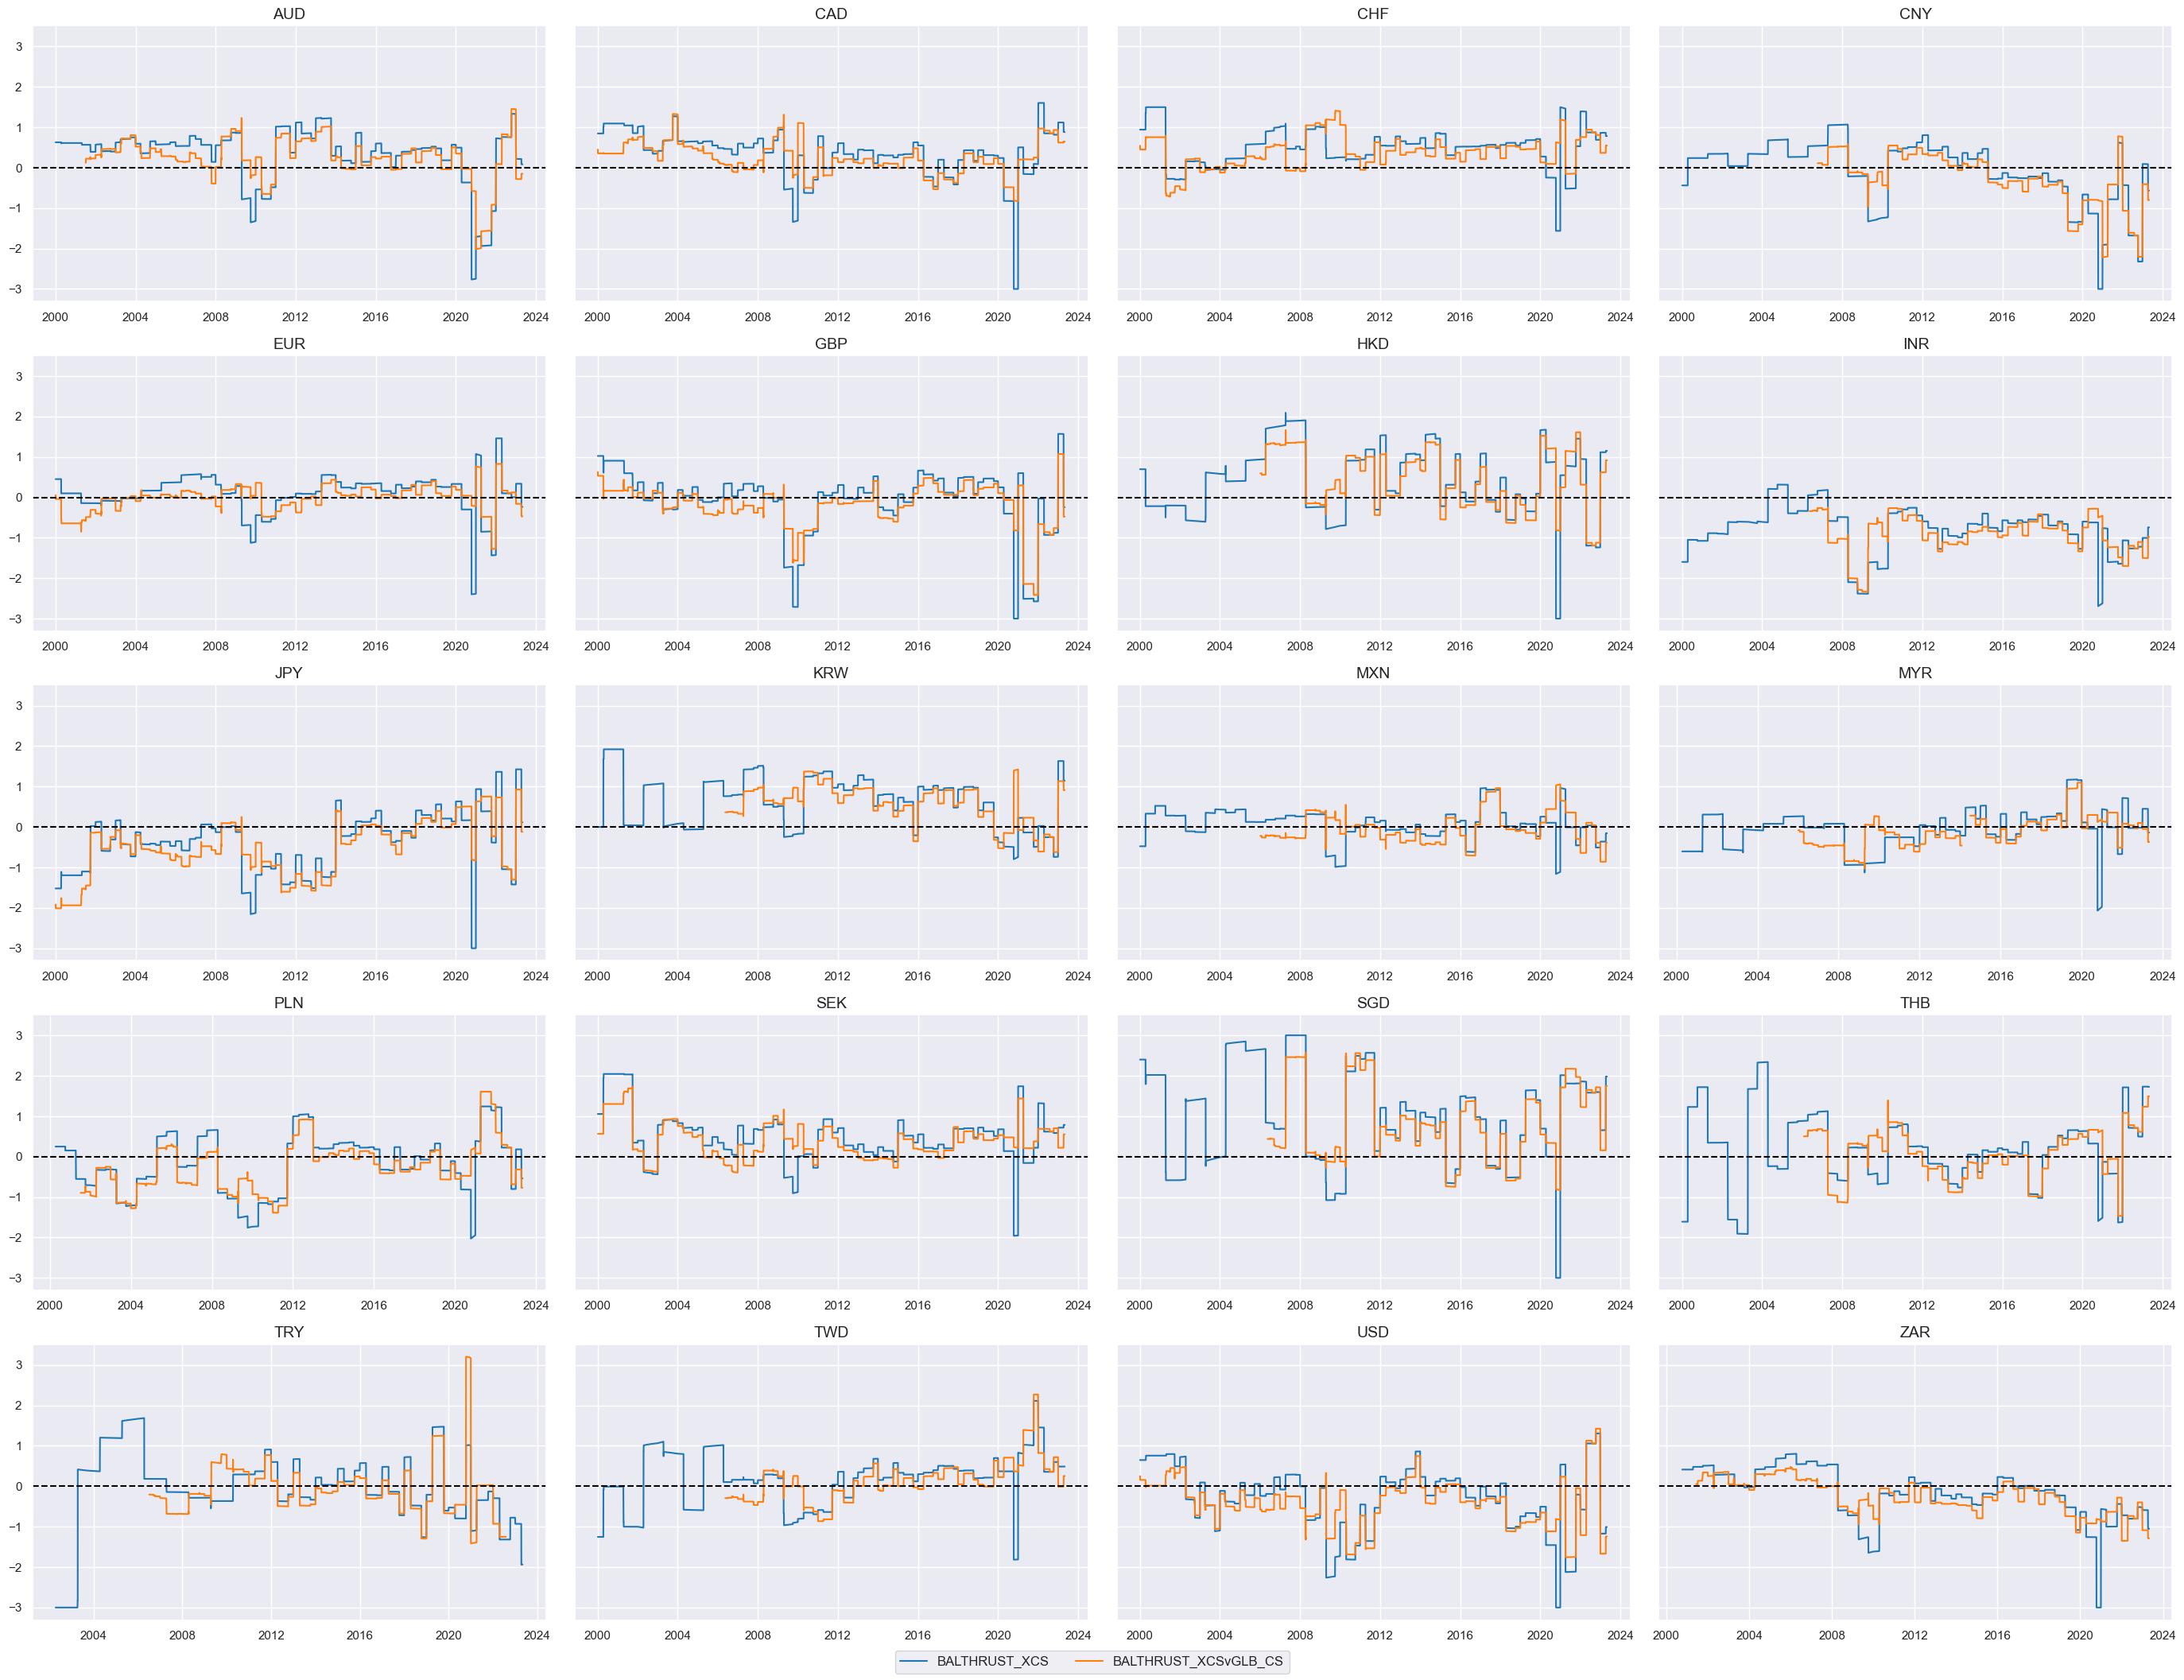

In [21]:
cidx = dict_cs["cids"]
xcatx = ["BALTHRUST_XCS", "BALTHRUST_XCSvGLB_CS"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="2000-01-01",
    same_y=True,
    size=(12, 12),
    all_xticks=True,

)

## Targets

The target returns of the below analysis are fixed receiver positions in 5-year interest swaps, targeted at 10% volatility to allow comparable risk-taking across all currency areas, relative to a basket of the currency areas. Outperformance or underperformance of countries has often been persistent over months or even years.

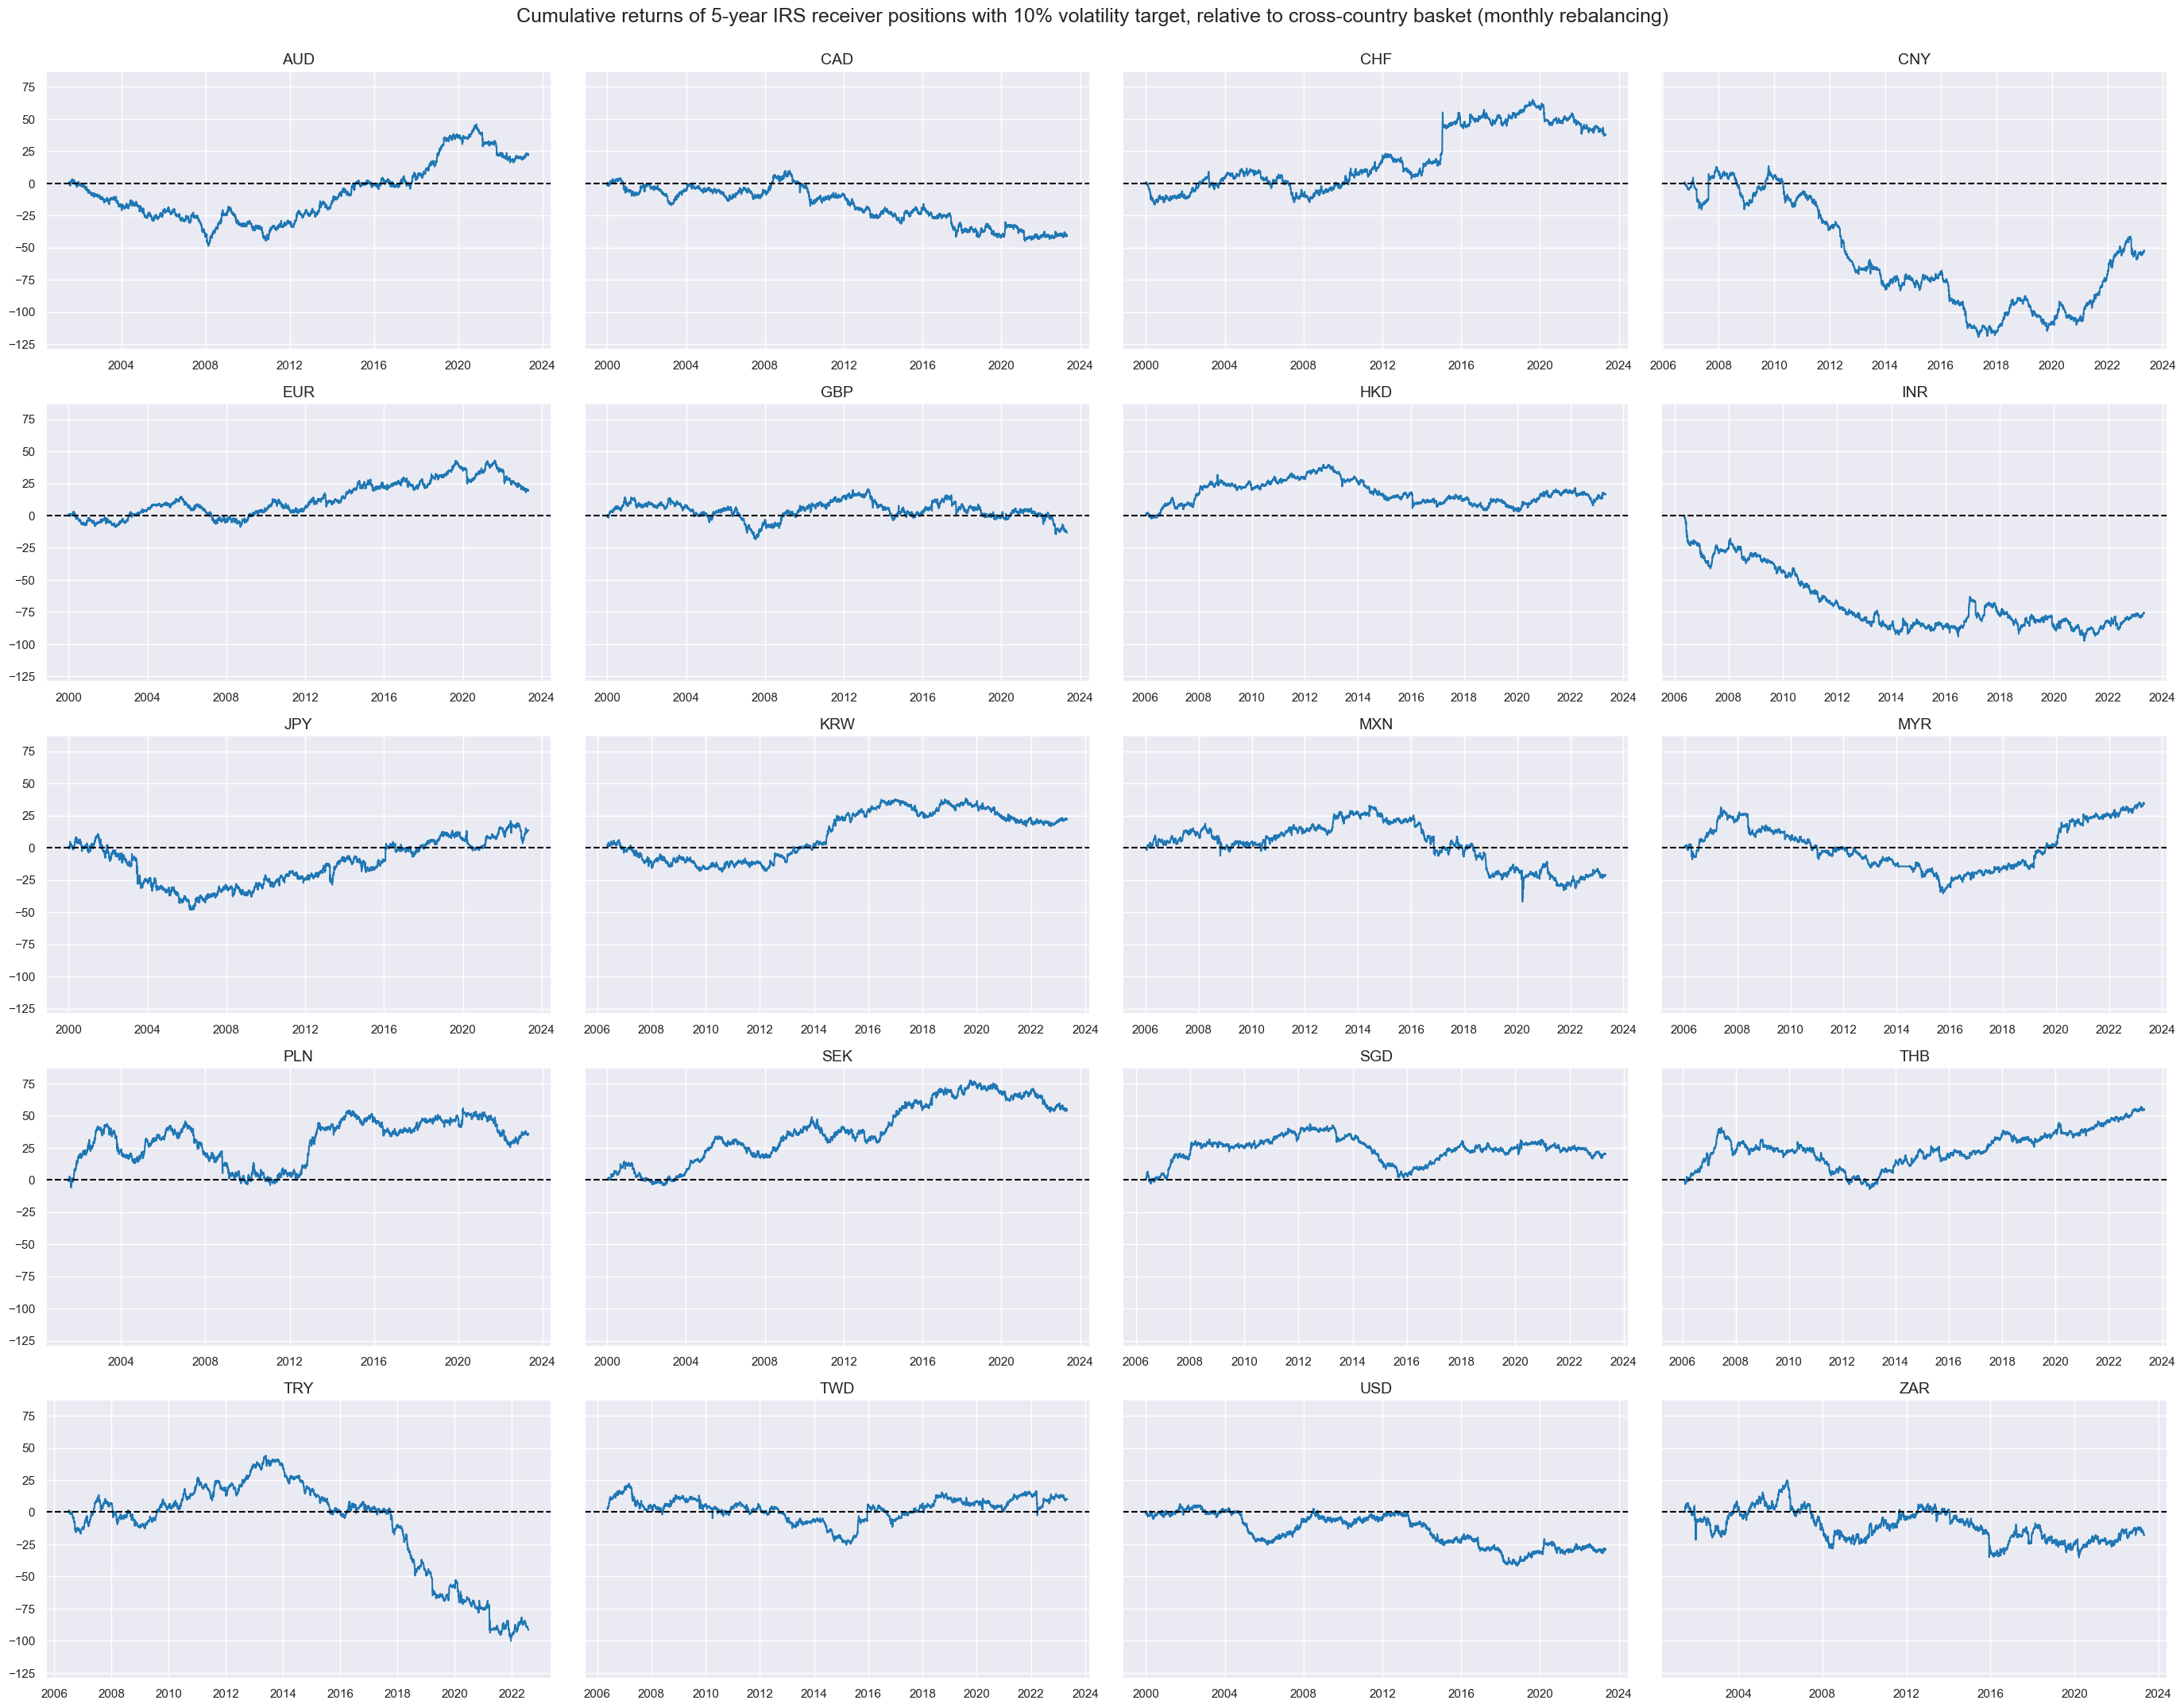

In [22]:
cidx = cids
xcatx = ["DU05YXR_VT10vGLB_CS"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title="Cumulative returns of 5-year IRS receiver positions with 10% volatility target, relative to cross-country basket (monthly rebalancing)",
  )

## Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for fixed income allocations, using the previously modified indicators. The PnLs are calculated based on simple trading strategies that utilize the created inflation measures as signals (no regression analysis is involved). The strategies involve going long (buying) or short (selling) on  Equity positions based purely on the direction of the excess inflation signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the strategy returns and the actual returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these fiscul indicator - based strategies with the long-only performance of the duration returns. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

The analysis in the post and sample code in the notebook is a proof of concept only, using the simplest design.

### Relative composite and duration

In [23]:
# Change the sign of thrust indicator

dfx_thr = dfx[dfx["xcat"] == "THRUSTvGLB_THR"]
dfx_thr["value"] = -dfx_thr["value"]
dfx_thr["xcat"] = "THRUSTvGLB_THRN"
dfx = msm.update_df(dfx, dfx_thr)

As in previous notebooks, we create a dictionary for naive PnL creation: we define main trading signal (composite relative fiscal indicator), alternative signals (relative balance gap and thrust), target (relative duration return), relevant cross sections and few other parameters. 

In [24]:
dix = dict_cs

dict_cs_rel = {
    "sig": "BALTHRUST_XCSvGLB_CS",
    "rivs": [
        "BALA_GAPvGLB_BAL",
        "THRUSTvGLB_THRN",
    ],
    "targ": "DU05YXR_VT10vGLB_CS",
    "cidx": dix["cids"],
    "black": dix["black"],
    "srr": None,
    "pnls": None,
}

with `CategoryRelations()` we can quickly visualise and analyse two categories (signal and target from the above dictionary). We define the lag and frequency (quarterly in our case)

In [25]:
dix = dict_cs_rel

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
)

Relative fiscal scores have indeed been positively correlated with subsequent relative IRS returns for the available panel of data. The probability of significance from 2000-2022 has been above 98% at monthly or quarterly frequencies. The correlation coefficient has been 5% at a monthly and 6% at a quarterly frequency, which is modest but respectable for a single low-frequency indicator that has not been optimized and uses no whatsoever market information. 

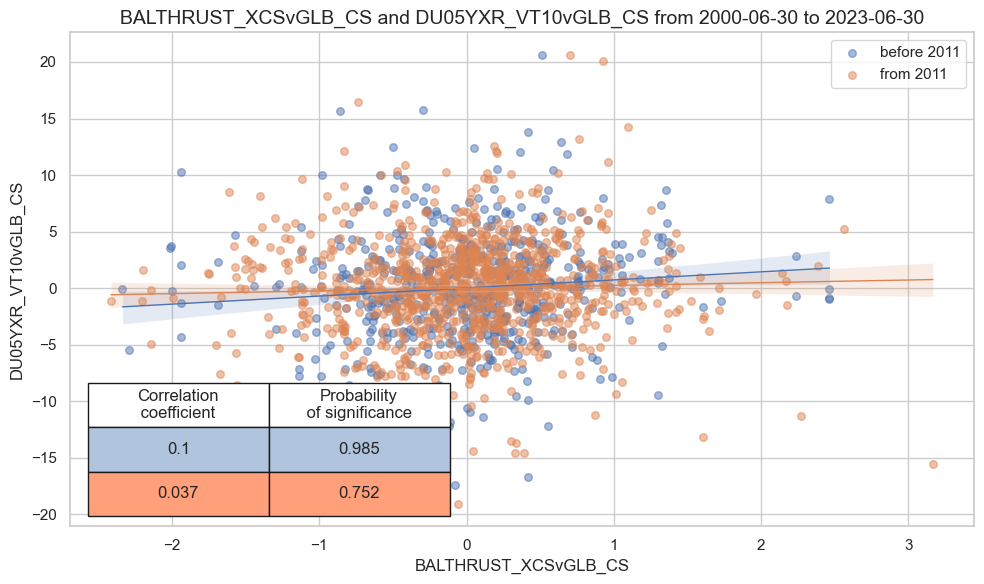

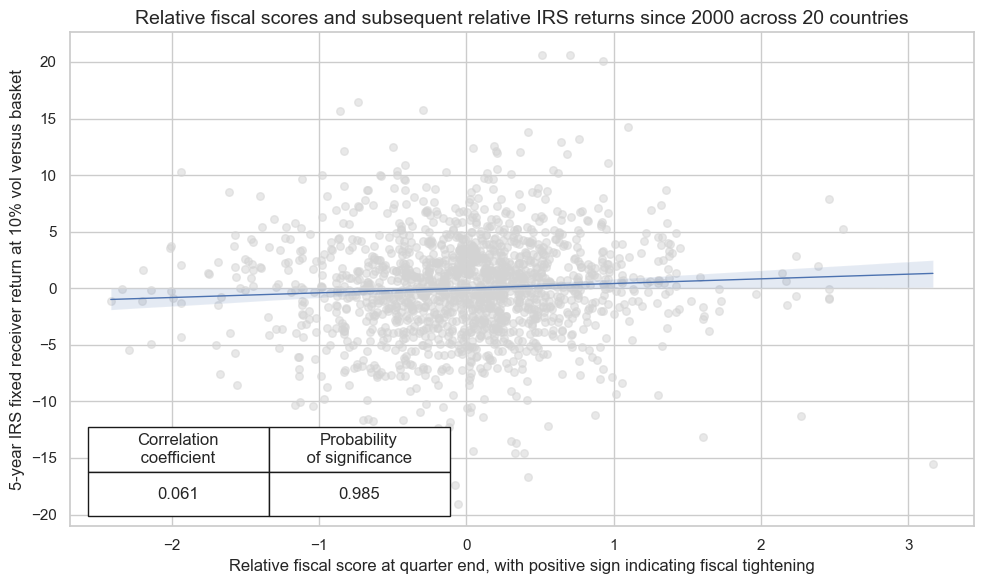

In [26]:
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator=2011,
    xlab=None,
    ylab=None,
    title=None,
    size=(10, 6),
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Relative fiscal score at quarter end, with positive sign indicating fiscal tightening",
    ylab="5-year IRS fixed receiver return at 10% vol versus basket",
    title="Relative fiscal scores and subsequent relative IRS returns since 2000 across 20 countries",
    size=(10, 6),
)

In [27]:
dix = dict_cs_rel

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=list(set(cidx) - set(["HKD", "CNY"])),
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="2002-01-01",
    blacklist=blax,
)

dix["srr"] = srr

In [28]:
dix = dict_cs_rel

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2002-01-01",
    blacklist=blax,
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=3,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

dix["pnls"] = naive_pnl

In [29]:
dix = dict_cs

dict_cs_rel = {
    "sig": "BALTHRUST_XCSvGLB_CS",
    "rivs": [
        "BALA_GAPvGLB_BAL",
        "THRUSTvGLB_THRN",
    ],
    "targ": "DU05YXR_VT10vGLB_CS",
    "cidx": dix["cids"],
    "black": dix["black"],
    "srr": None,
    "pnls": None,
}

In [30]:
dix = dict_cs_rel

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=list(set(cidx) - set(["HKD", "CNY"])),
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="2002-01-01",
    blacklist=blax,
)

dix["srr"] = srr

In [31]:
dix = dict_cs_rel
srrx = dix["srr"]

In [32]:
display(srrx.summary_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
M: BALTHRUST_XCSvGLB_CS/last => DU05YXR_VT10vGLB_CS,0.506,0.506,0.509,0.514,0.519,0.492,0.053,0.001,0.023,0.029,0.506
Mean years,0.507,0.508,0.509,0.515,0.520,0.495,0.060,0.380,0.025,0.410,0.508
Positive ratio,0.545,0.545,0.500,0.727,0.682,0.409,0.773,0.591,0.682,0.455,0.545
Mean cids,0.506,0.503,0.508,0.514,0.492,0.484,0.041,0.400,0.013,0.479,0.501
Positive ratio,0.667,0.556,0.500,0.611,0.611,0.222,0.778,0.444,0.778,0.389,0.500


In [33]:
dix = dict_cs_rel
srrx = dix["srr"]

In [34]:
display(srrx.signals_table().astype("float").round(3))

accuracy  \
Return              Signal               Frequency Aggregation             
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last            0.506   
                    BALA_GAPvGLB_BAL     M         last            0.506   
                    THRUSTvGLB_THRN      M         last            0.498   

                                                                bal_accuracy  \
Return              Signal               Frequency Aggregation                 
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last                0.506   
                    BALA_GAPvGLB_BAL     M         last                0.506   
                    THRUSTvGLB_THRN      M         last                0.498   

                                                                pos_sigr  \
Return              Signal               Frequency Aggregation             
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last            0.509   
                    BALA_GAPvGLB_BAL     M         last            0.476   
                    THRUSTvGLB_THRN      M         last            0.506   

                                                                pos_retr  \
Return              Signal               Frequency Aggregation             
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last            0.514   
                    BALA_GAPvGLB_BAL     M         last            0.514   
                    THRUSTvGLB_THRN      M         last            0.514   

                                                                pos_prec  \
Return              Signal               Frequency Aggregation             
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last            0.519   
                    BALA_GAPvGLB_BAL     M         last            0.520   
                    THRUSTvGLB_THRN      M         last            0.511   

                                                                neg_prec  \
Return              Signal               Frequency Aggregation             
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last            0.492   
                    BALA_GAPvGLB_BAL     M         last            0.492   
                    THRUSTvGLB_THRN      M         last            0.484   

                                                                pearson  \
Return              Signal               Frequency Aggregation            
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last           0.053   
                    BALA_GAPvGLB_BAL     M         last           0.040   
                    THRUSTvGLB_THRN      M         last           0.034   

                                                                pearson_pval  \
Return              Signal               Frequency Aggregation                 
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last                0.001   
                    BALA_GAPvGLB_BAL     M         last                0.010   
                    THRUSTvGLB_THRN      M         last                0.029   

                                                                kendall  \
Return              Signal               Frequency Aggregation            
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last           0.023   
                    BALA_GAPvGLB_BAL     M         last           0.017   
                    THRUSTvGLB_THRN      M         last           0.009   

                                                                kendall_pval  \
Return              Signal               Frequency Aggregation                 
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last                0.029   
                    BALA_GAPvGLB_BAL     M         last                0.097   
                    THRUSTvGLB_THRN      M         last                0.398   

                                                                  auc  
Return              Signal               Frequency Aggregation         
DU05YXR_VT10vGLB_CS BALTHRUST_XCSvGLB_CS M         last     

In [35]:
dix = dict_cs_rel
srrx = dix["srr"]

In [36]:
display(srrx.cross_section_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
M: BALTHRUST_XCSvGLB_CS/last => DU05YXR_VT10vGLB_CS,0.506,0.506,0.509,0.514,0.519,0.492,0.053,0.001,0.023,0.029,0.506
Mean,0.506,0.503,0.508,0.514,0.492,0.484,0.041,0.400,0.013,0.479,0.501
PosRatio,0.667,0.556,0.500,0.611,0.611,0.222,0.778,0.444,0.778,0.389,0.500
AUD,0.492,0.492,0.762,0.496,0.492,0.492,0.146,0.020,0.027,0.520,0.494
CAD,0.484,0.489,0.742,0.484,0.479,0.500,0.012,0.852,0.009,0.832,0.492
CHF,0.543,0.513,0.859,0.551,0.555,0.472,0.086,0.172,0.025,0.552,0.507
EUR,0.492,0.485,0.625,0.523,0.512,0.458,0.065,0.297,0.019,0.650,0.486
GBP,0.477,0.469,0.332,0.488,0.447,0.491,0.033,0.596,0.015,0.726,0.473
INR,0.515,0.515,0.000,0.485,0.000,0.515,-0.087,0.215,-0.106,0.025,0.500
JPY,0.508,0.535,0.258,0.539,0.591,0.479,0.038,0.541,0.013,0.759,0.527


In [37]:
dix = dict_cs_rel

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2002-01-01",
    blacklist=blax,
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=3,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

dix["pnls"] = naive_pnl

The value generated by simply allocating fixed-income risk according to the fiscal expansion score has been considerable and quite consistent across time. The below shows an approximate PnL based on the standard normalized fiscal scores across all 20 countries (for the periods when signals were available and the market was tradable) and monthly rebalancing of positions in accordance with signal values. Positions are changed on the first trading day of the month and are assumed to have been updated by the beginning of the second trading day. The PnL chart has been normalized to 10% annualized volatility. This PnL is “naïve” insofar as we do not consider transaction costs and standard risk-management tools.

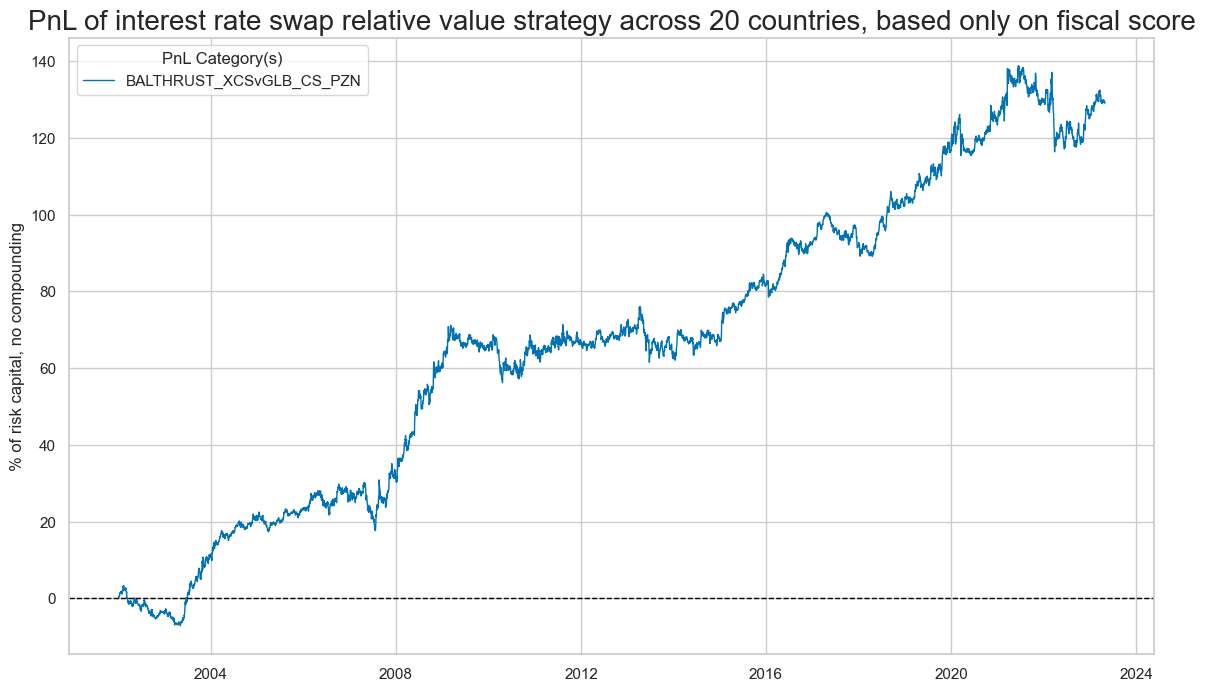

In [38]:
dix = dict_cs_rel

sigx = [dix["sig"]]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="PnL of interest rate swap relative value strategy across 20 countries, based only on fiscal score",
    xcat_labels=None,
    figsize=(14, 8),
)

In [39]:
dix = dict_cs_rel

sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)

In [40]:
display(df_eval)

xcat,BALA_GAPvGLB_BAL_PZN,BALTHRUST_XCSvGLB_CS_PZN,THRUSTvGLB_THRN_PZN
Return %,4.12229,6.060117,4.579222
St. Dev. %,10.0,10.0,10.0
Sharpe Ratio,0.412229,0.606012,0.457922
Sortino Ratio,0.593947,0.916292,0.683846
Max 21-Day Draw %,-14.996164,-18.18576,-10.396845
Max 6-Month Draw %,-19.326884,-18.177349,-16.452656
Peak to Trough Draw %,-32.887527,-22.412372,-21.857501
Top 5% Monthly PnL Share,0.951962,0.601829,0.820321
Traded Months,257,257,257


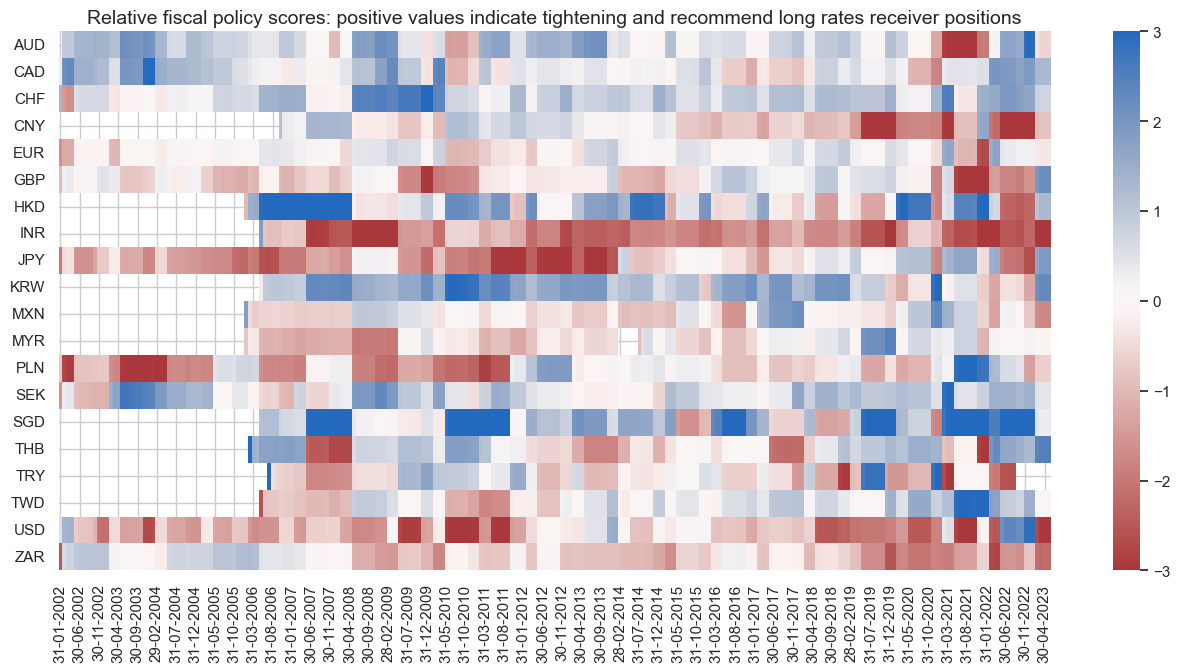

In [41]:
dix = dict_cs_rel
sig = dix["sig"]
naive_pnl = dix["pnls"]

naive_pnl.signal_heatmap(
    pnl_name=sig + "_PZN",
    freq="m",
    start="2000-01-01",
    figsize=(16, 7),
    title="Relative fiscal policy scores: positive values indicate tightening and recommend long rates receiver positions",
)